In [345]:
import sys
import os

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from src.model import *
from src.dataset import MyDataset, WeakDataset
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm
from IPython.display import clear_output

from sklearn.linear_model import LinearRegression
from scipy import stats

from src.utils import (
    set_seed,
    root_dir,
    save_ckpt,
    load_ckpt,
    log_meters,
    plot_losses,
    reset_meters,
    create_meters,
    print_cfg_info,
    load_data_scaler,
)

class Wasserstein():
    
    def __init__(self, eps, device=torch.device("cpu")):
        self.eps = eps
        self.device = device
        
    def forward(self, a, b, C, n_iter=100):
        K = torch.exp(-C/self.eps)
        v = torch.ones(b.shape[0], device=self.device)
        for _ in range(n_iter):
            u = a / (K@v)
            v = b / (K.T@u)
            
        return ((torch.diag(u)@K)@torch.diag(v))
        
    def __call__(self, a, b, C, n_iter=100):
        return self.forward(a, b, C, n_iter)

In [346]:
cfg = {
    "z_dim": 256,
    "gen_dims": [128, 32, 8, 4],
    "disc_dims": [4, 128, 32, 8],
    "num_epochs": 1000,
    "batch_size": 200,
    "w_gp": 10,
    "w_eps": 1e-3,
    "w_weak":1e-3,
    "display_freq": 10,
    "schedule_freq": 2500,
    "seed": 5051,
    "device": torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"),
    "from_epoch": 2,
    "iter_d":1,
}

cgf_model = {
    
}

cfg_dataset = {
    'n_samples_train':25,
    'n_samples_weak':975,
    'n_samples_test':1000,
}

cfg_make_reg = {
    'n_samples':cfg_dataset['n_samples_train']\
                +cfg_dataset['n_samples_weak']\
                +cfg_dataset['n_samples_test'],
    'n_features':20,
    'n_informative':20,
    'n_targets':2,
    'shuffle':False,
    "noise":0,
}

cfg_loader = {  
    "batch_size":cfg["batch_size"],
    "drop_last":False,
}

In [347]:
data = pd.read_csv("data/insurance.csv")
X, y = data.drop("charges", axis=1), data["charges"]

encoder = OneHotEncoder()
encoder.fit(X.loc[:, ["sex", "children", "smoker", "region"]])
X_cat = np.array(encoder.transform(X.loc[:, ["sex", "children", "smoker", "region"]]).todense())

X_full = np.concatenate([X[["age", "bmi"]].to_numpy(), X_cat], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_full, y.to_numpy()[:, None], test_size=0.25)

scalerX = StandardScaler()
scalerX.fit(X_train)

scalerY = StandardScaler()
scalerY.fit(y_train)

X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test)
y_train = scalerY.transform(y_train)
y_test = scalerY.transform(y_test)

X_train, X_weak, y_train, y_weak = train_test_split(X_train, y_train, test_size=0.6)

X_train_torch = torch.Tensor(X_train).to(cfg["device"])
y_train_torch = torch.Tensor(y_train).to(cfg["device"])
X_weak_torch = torch.Tensor(X_weak).to(cfg["device"])
X_test_torch = torch.Tensor(X_test).to(cfg["device"])
y_test_torch = torch.Tensor(y_test).to(cfg["device"])

In [348]:
train_loader = MyDataset(X_train, y_train, batch_size=cfg["batch_size"], device=cfg["device"])
test_loader = MyDataset(X_test, y_test, batch_size=cfg["batch_size"], device=cfg["device"])
weak_loader = WeakDataset(X_weak, batch_size=cfg["batch_size"]//2, device=cfg["device"])

In [349]:
netR = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1]),
).to(cfg["device"])
optimR = Adam(netR.parameters(), lr=1e-2)

meter_names = ['L2_Loss_Train','L2_Loss_Test']
meters = create_meters(meter_names)

L2 = nn.MSELoss()

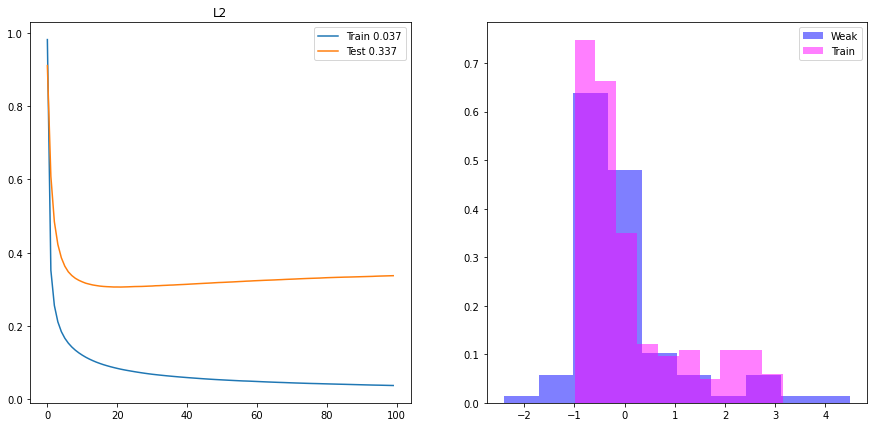

In [350]:
losses = [[], []]
for e in range(cfg['num_epochs']):
    for X_batch, y_batch in train_loader:
        ### Regressor
        optimR.zero_grad()
        y_pred = netR(X_batch)
        loss = L2(y_pred, y_batch)
        loss.backward()
        optimR.step()

        meters["L2_Loss_Train"].update(loss.item())


    if not e % cfg["display_freq"]:
        clear_output(wait=True)
        with torch.no_grad():
            y_pred = netR(X_test_torch)
            loss = L2(y_pred, y_test_torch).item()
        y_weak = netR(weak_loader.sample())
        meters["L2_Loss_Test"].update(loss)
        
        losses[0].append(meters["L2_Loss_Train"].avg)
        losses[1].append(meters["L2_Loss_Test"].avg)
    
        plt.figure(figsize=(15, 7))
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122)

        ax1.set_title("L2")
        ax1.plot(losses[0], label="Train {:.3f}".format(losses[0][-1]))
        ax1.plot(losses[1], label="Test {:.3f}".format(losses[1][-1]))
        ax1.legend()
        
        ax2.hist(y_weak.cpu().detach().numpy(), label='Weak', fc=(0, 0, 1, 0.5), density=True)
        ax2.hist(y_batch.cpu().detach().numpy(), label='Train',  fc=(1, 0, 1, 0.5), density=True)
        ax2.legend()
        plt.show()

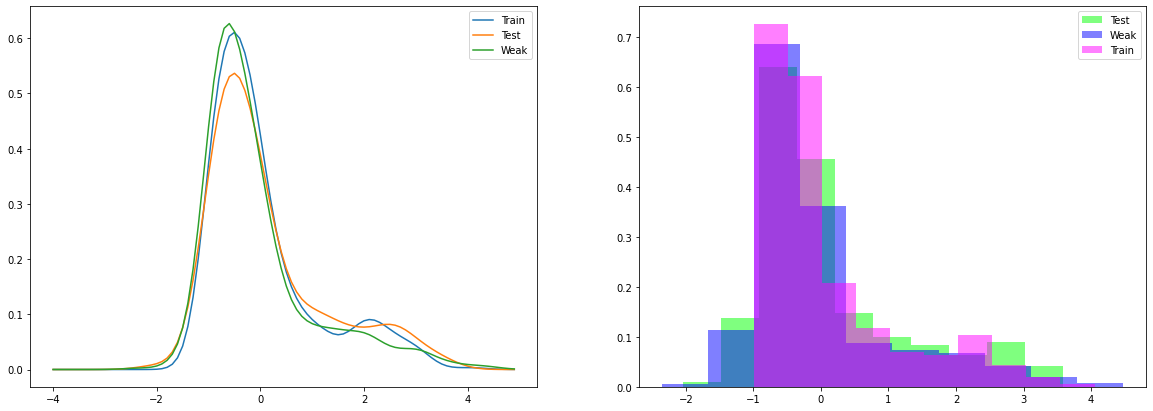

In [351]:
x = np.arange(-40, 50)/10
density_train = stats.kde.gaussian_kde(y_train.flatten())
density_test = stats.kde.gaussian_kde(netR(X_test_torch).cpu().detach().numpy().flatten())
density_weak = stats.kde.gaussian_kde(netR(X_weak_torch).cpu().detach().numpy().flatten())

plt.figure(figsize=(20, 7))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.plot(x, density_train(x), label='Train')
ax1.plot(x, density_test(x), label='Test')
ax1.plot(x, density_weak(x), label='Weak')
ax1.legend()

ax2.hist(netR(X_test_torch).cpu().detach().numpy(), label='Test', fc=(0, 1, 0, 0.5), density=True)
ax2.hist(netR(X_weak_torch).cpu().detach().numpy(), label='Weak', fc=(0, 0, 1, 0.5), density=True)
ax2.hist(y_train, label='Train',  fc=(1, 0, 1, 0.5), density=True)
ax2.legend()
plt.show()

### Conditional OT

In [352]:
netR = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1]),
).to(cfg["device"])

optimR = Adam(netR.parameters(), lr=1e-2)

meter_names = ['L2_Loss_Train','L2_Loss_Test']
meters = create_meters(meter_names)

L2 = nn.MSELoss()
W = Wasserstein(0.01, device=cfg["device"])

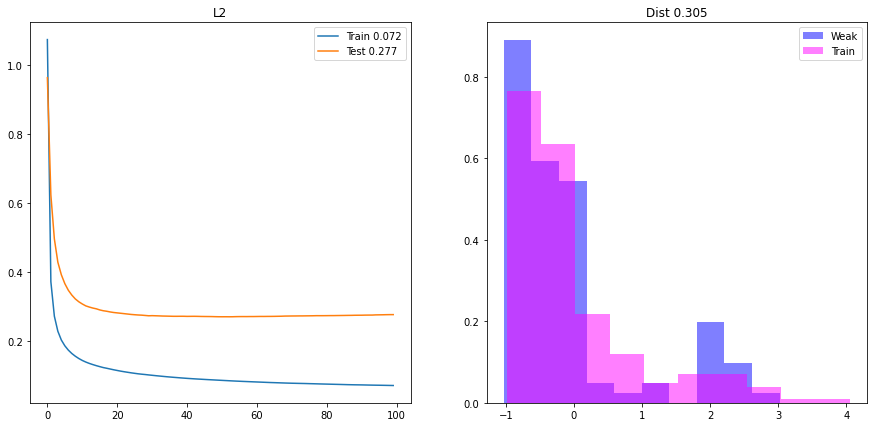

In [353]:
losses = [[], []]
for e in range(cfg['num_epochs']):
    for X_batch, y_batch in train_loader:
        ### Regressor
        optimR.zero_grad()
        X_batch_weak = weak_loader.sample()
        y_weak = netR(X_batch_weak)
        C = torch.cdist(y_batch, y_weak, p=2)
        C_X = (torch.cdist(X_batch, X_batch_weak, p=2) + C)/2
        with torch.no_grad():
            a = torch.ones(y_batch.shape[0], device=cfg["device"])/y_batch.shape[0]
            b = torch.ones(y_weak.shape[0], device=cfg["device"])/y_weak.shape[0]
            P = W(a, b, C_X/C_X.max(), 100)
            
        y_pred = netR(X_batch)
        
        L2_loss = L2(y_pred, y_batch)
        W_loss = (P*C).sum()
        loss = W_loss + L2_loss
        
        loss.backward()
        optimR.step()

        meters["L2_Loss_Train"].update(L2_loss.item())
        
    if not e % cfg["display_freq"]:
        clear_output(wait=True)
        with torch.no_grad():
            y_pred = netR(X_test_torch)
            loss = L2(y_pred, y_test_torch).item()

        meters["L2_Loss_Test"].update(loss)
        
        losses[0].append(meters["L2_Loss_Train"].avg)
        losses[1].append(meters["L2_Loss_Test"].avg)
    
        plt.figure(figsize=(15, 7))
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122)

        ax1.set_title("L2")
        ax1.plot(losses[0], label="Train {:.3f}".format(losses[0][-1]))
        ax1.plot(losses[1], label="Test {:.3f}".format(losses[1][-1]))
        ax1.legend()
        
        ax2.set_title("Dist {:.3f}".format(W_loss.item()))
        ax2.hist(y_weak.cpu().detach().numpy(), label='Weak', fc=(0, 0, 1, 0.5), density=True)
        ax2.hist(y_batch.cpu().detach().numpy(), label='Train',  fc=(1, 0, 1, 0.5), density=True)
        ax2.legend()
        plt.show()

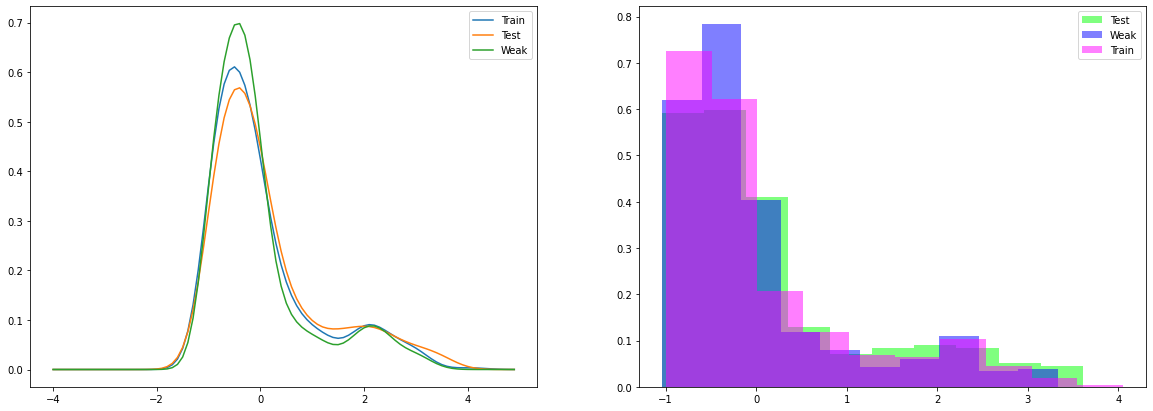

In [354]:
x = np.arange(-40, 50)/10
density_train = stats.kde.gaussian_kde(y_train.flatten())
density_test = stats.kde.gaussian_kde(netR(X_test_torch).cpu().detach().numpy().flatten())
density_weak = stats.kde.gaussian_kde(netR(X_weak_torch).cpu().detach().numpy().flatten())

plt.figure(figsize=(20, 7))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.plot(x, density_train(x), label='Train')
ax1.plot(x, density_test(x), label='Test')
ax1.plot(x, density_weak(x), label='Weak')
ax1.legend()

ax2.hist(netR(X_test_torch).cpu().detach().numpy(), label='Test', fc=(0, 1, 0, 0.5), density=True)
ax2.hist(netR(X_weak_torch).cpu().detach().numpy(), label='Weak', fc=(0, 0, 1, 0.5), density=True)
ax2.hist(y_train, label='Train',  fc=(1, 0, 1, 0.5), density=True)
ax2.legend()
plt.show()

In [285]:
netR = nn.Sequential(
    nn.Linear(X_train.shape[1], 16),
    nn.ReLU(),
    nn.Linear(16, y_train.shape[1]),
).to(cfg["device"])

optimR = Adam(netR.parameters(), lr=1e-2)

meter_names = ['L2_Loss_Train','L2_Loss_Test']
meters = create_meters(meter_names)

L2 = nn.MSELoss()
W = Wasserstein(0.01, device=cfg["device"])

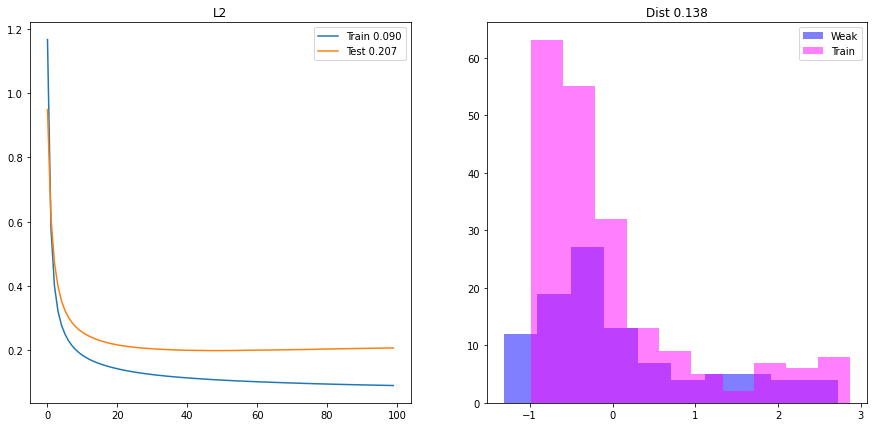

In [286]:
losses = [[], []]
for e in range(cfg['num_epochs']):
    for X_batch, y_batch in train_loader:
        ### Regressor
        optimR.zero_grad()
        X_batch_weak = weak_loader.sample()
        y_weak = netR(X_batch_weak)
        C = torch.cdist(y_batch, y_weak, p=2)
        C_X = (torch.cdist(X_batch, X_batch_weak, p=2) + C)/2
        with torch.no_grad():
            a = torch.ones(y_batch.shape[0], device=cfg["device"])/y_batch.shape[0]
            b = torch.ones(y_weak.shape[0], device=cfg["device"])/y_weak.shape[0]
            P = W(a, b, C_X/C_X.max(), 100)
            
        y_pred = netR(X_batch)
        
        L2_loss = L2(y_pred, y_batch)
        W_loss = 0.1*(P*C_X).sum()
        loss = W_loss + L2_loss
        
        loss.backward()
        optimR.step()

        meters["L2_Loss_Train"].update(L2_loss.item())
        
    if not e % cfg["display_freq"]:
        clear_output(wait=True)
        with torch.no_grad():
            y_pred = netR(X_test_torch)
            loss = L2(y_pred, y_test_torch).item()

        meters["L2_Loss_Test"].update(loss)
        
        losses[0].append(meters["L2_Loss_Train"].avg)
        losses[1].append(meters["L2_Loss_Test"].avg)
    
        plt.figure(figsize=(15, 7))
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122)

        ax1.set_title("L2")
        ax1.plot(losses[0], label="Train {:.3f}".format(losses[0][-1]))
        ax1.plot(losses[1], label="Test {:.3f}".format(losses[1][-1]))
        ax1.legend()
        
        ax2.set_title("Dist {:.3f}".format(W_loss.item()))
        ax2.hist(y_weak.cpu().detach().numpy(), label='Weak', fc=(0, 0, 1, 0.5))
        ax2.hist(y_batch.cpu().detach().numpy(), label='Train',  fc=(1, 0, 1, 0.5))
        ax2.legend()
        plt.show()

### Softmin

In [98]:
netR = nn.Sequential(
    nn.Linear(X_train.shape[1], 16),
    nn.ReLU(),
    nn.Linear(16, y_train.shape[1]),
).to(cfg["device"])

optimR = Adam(netR.parameters(), lr=1e-2)

meter_names = ['L2_Loss_Train','L2_Loss_Test']
meters = create_meters(meter_names)

L2 = nn.MSELoss()

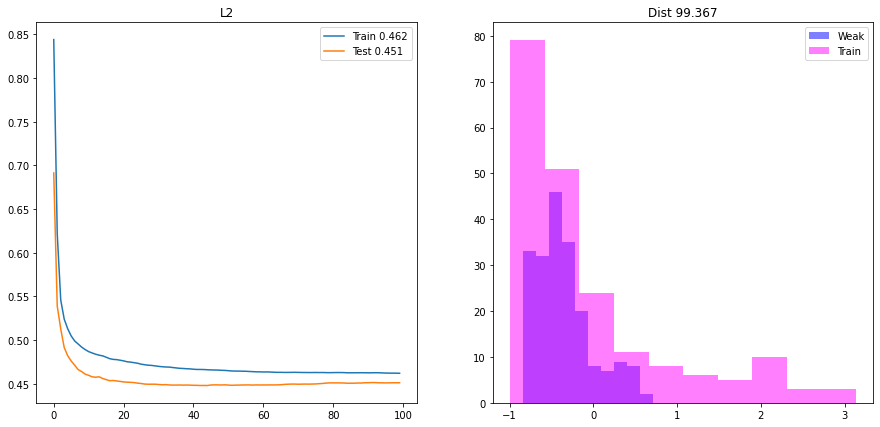

In [99]:
losses = [[], []]
for e in range(cfg['num_epochs']):
    for X_batch, y_batch in train_loader:
        ### Regressor
        optimR.zero_grad()
        X_batch_weak = weak_loader.sample()
        y_weak = netR(X_batch_weak)
        C = torch.cdist(y_weak, y_batch, p=2)
        with torch.no_grad():
            C_X = torch.nn.functional.softmin(torch.cdist(X_batch_weak, X_batch, p=2), dim=1)
            
        y_pred = netR(X_batch)
        L2_loss = L2(y_pred, y_batch)
        W_loss = (C_X*C).sum()
        loss = W_loss
        loss.backward()
        optimR.step()

        meters["L2_Loss_Train"].update(L2_loss.item())
        
    if not e % cfg["display_freq"]:
        clear_output(wait=True)
        with torch.no_grad():
            y_pred = netR(X_test_torch)
            loss = L2(y_pred, y_test_torch).item()

        meters["L2_Loss_Test"].update(loss)
        
        losses[0].append(meters["L2_Loss_Train"].avg)
        losses[1].append(meters["L2_Loss_Test"].avg)
    
        plt.figure(figsize=(15, 7))
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122)

        ax1.set_title("L2")
        ax1.plot(losses[0], label="Train {:.3f}".format(losses[0][-1]))
        ax1.plot(losses[1], label="Test {:.3f}".format(losses[1][-1]))
        ax1.legend()
        
        ax2.set_title("Dist {:.3f}".format(W_loss.item()))
        ax2.hist(y_weak.cpu().detach().numpy(), label='Weak', fc=(0, 0, 1, 0.5))
        ax2.hist(y_batch.cpu().detach().numpy(), label='Train',  fc=(1, 0, 1, 0.5))
        ax2.legend()
        plt.show()

### Measure estimation

In [185]:
from torch import distributions
from torch.nn.parameter import Parameter

class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J += s.sum(dim=1)
        return z, log_det_J
    
    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp
        
    def sample(self, batchSize): 
        z = self.prior.sample((batchSize, 1))
        logp = self.prior.log_prob(z)
        x = self.g(z)
        return x

In [186]:
nets = lambda: nn.Sequential(nn.Linear(2, 16), nn.ReLU(), nn.Linear(16, 2), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(2, 16), nn.ReLU(), nn.Linear(16, 2))
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 1).astype(np.float32))
prior = distributions.MultivariateNormal(torch.zeros(2).to(cfg["device"]), torch.eye(2).to(cfg["device"]))
flow = RealNVP(nets, nett, masks, prior)

flow = flow.to(cfg["device"])
y_all = np.concatenate([scalerY.transform(y.to_numpy()[:, None]),
                        scalerY.transform(y.to_numpy()[:, None])], axis=1)

In [187]:
dataset_y_all = WeakDataset(y_all, batch_size=100, device=cfg["device"])

optNVP = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-3)
schedNVP = torch.optim.lr_scheduler.ExponentialLR(optNVP, gamma=0.1)
for e in (pbar := tqdm(range(1000))):
    err = 0
    n_elem = 0
    for y_batch in dataset_y_all:
        optNVP.zero_grad()
        loss = -flow.log_prob(y_batch).sum()
        loss.backward(retain_graph=True)
        optNVP.step()
        
        err += loss.item()
        n_elem += y_batch.shape[0]

    pbar.set_description('loss = %.3f' % (err/n_elem))
    if e % 100 == 0:
        schedNVP.step()

loss = 0.603: 100% 1000/1000 [00:57<00:00, 17.45it/s]


In [188]:
netR = nn.Sequential(
    nn.Linear(X_train.shape[1], 16),
    nn.ReLU(),
    nn.Linear(16, y_train.shape[1]),
).to(cfg["device"])

optimR = Adam(netR.parameters(), lr=1e-2)

meter_names = ['L2_Loss_Train','L2_Loss_Test']
meters = create_meters(meter_names)

L2 = nn.MSELoss()

In [ ]:
losses = [[], []]
for e in range(cfg['num_epochs']):
    for X_batch, y_batch in train_loader:
        ### Regressor
        optimR.zero_grad()
        X_batch_weak = weak_loader.sample()
        
        y_pred = netR(X_batch)
        y_weak = netR(X_batch_weak)
        
        L2_loss = L2(y_pred, y_batch)
        F_Loss = -flow.log_prob(y_weak).mean()
        loss = F_Loss
        
        loss.backward()
        optimR.step()

        meters["L2_Loss_Train"].update(L2_loss.item())
        
    if not e % cfg["display_freq"]:
        clear_output(wait=True)
        with torch.no_grad():
            y_pred = netR(X_test_torch)
            loss = L2(y_pred, y_test_torch).item()

        meters["L2_Loss_Test"].update(loss)
        
        losses[0].append(meters["L2_Loss_Train"].avg)
        losses[1].append(meters["L2_Loss_Test"].avg)
    
        plt.figure(figsize=(15, 7))
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122)

        ax1.set_title("L2")
        ax1.plot(losses[0], label="Train {:.3f}".format(losses[0][-1]))
        ax1.plot(losses[1], label="Test {:.3f}".format(losses[1][-1]))
        ax1.legend()
        
        ax2.set_title("Dist {:.3f}".format(F_Loss.item()))
        ax2.hist(y_weak.cpu().detach().numpy(), label='Weak', fc=(0, 0, 1, 0.5))
        ax2.hist(y_batch.cpu().detach().numpy(), label='Train',  fc=(1, 0, 1, 0.5))
        ax2.legend()
        plt.show()

### GANs

In [219]:
netR = nn.Sequential(
    nn.Linear(X_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1]),
).to(cfg["device"])

netD = nn.Sequential(
    nn.Linear(y_train.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, 1)
).to(cfg["device"])

optimR = Adam(netR.parameters(), lr=1e-2)
optimD = Adam(netD.parameters(), lr=1e-3)
optimG = Adam(netR.parameters(), lr=1e-3)

meter_names = ['L2_Loss_Train','L2_Loss_Test']
meters = create_meters(meter_names)


schedR = torch.optim.lr_scheduler.ExponentialLR(optimR, gamma=0.5)
schedD = torch.optim.lr_scheduler.ExponentialLR(optimD, gamma=0.5)

L2 = nn.MSELoss()
cfg["iter_d"] = 20

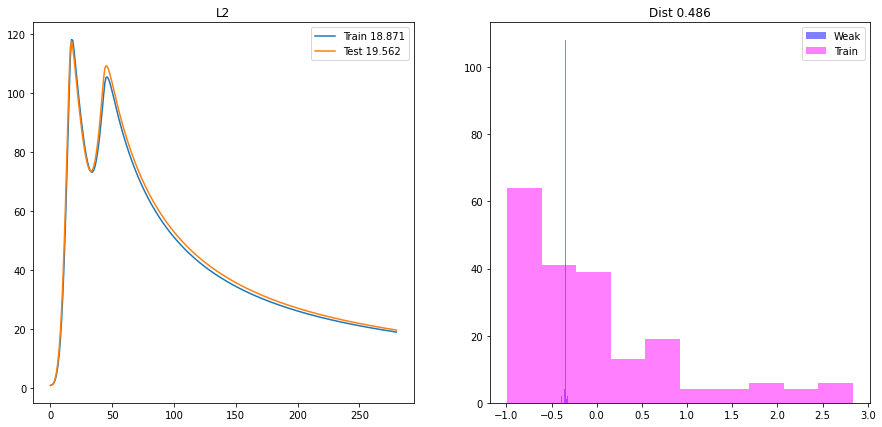

KeyboardInterrupt: 

In [220]:
losses = [[], []]
for e in range(10000):
    for X_batch, y_batch in train_loader:
        ### Regressor
        #optimR.zero_grad()
        y_pred = netR(X_batch)
        loss = L2(y_pred, y_batch)
        #loss.backward()
        #optimR.step()
        meters["L2_Loss_Train"].update(loss.item())

        ### Descriminator
        optimD.zero_grad()
        X_batch_weak = weak_loader.sample()

        with torch.no_grad():
            fake = netR(X_batch_weak)
            real = y_batch

        e_fake = netD(fake).mean()
        e_real = netD(real).mean()

        netD_loss = e_fake - e_real

        eps_pen = e_real ** 2
        eps_loss = eps_pen.mean()
        mix_alpha = torch.rand((len(real), 1), device=cfg['device'])
        mixed = mix_alpha * real + (1 - mix_alpha) * fake
        mixed.requires_grad_(True)
        mixed_preds = netD(mixed).sum()
        grads = torch.autograd.grad(
            outputs=mixed_preds,
            inputs=mixed,
            create_graph=True,
            retain_graph=True,
        )[0]
        grads = grads.view(len(real), -1)
        grad_loss = ((grads.norm(2, dim=-1) - 1) ** 2).mean()

        netD_total_loss = netD_loss + cfg['w_gp'] * grad_loss + cfg['w_eps'] * eps_loss
        netD_total_loss.backward()
        optimD.step()

        optimG.zero_grad()
        optimD.zero_grad()

        fake = netR(X_batch_weak)
        netG_pred = netD(fake)
        netG_loss = -netG_pred.mean()
        netG_loss_total = netG_loss
        netG_loss_total.backward()
        optimG.step()



    if not e % cfg["display_freq"]:
        clear_output(wait=True)
        with torch.no_grad():
            y_pred = netR(X_test_torch)
            loss = L2(y_pred, y_test_torch).item()

        meters["L2_Loss_Test"].update(loss)
        
        losses[0].append(meters["L2_Loss_Train"].avg)
        losses[1].append(meters["L2_Loss_Test"].avg)
    
        plt.figure(figsize=(15, 7))
        ax1 = plt.subplot(121)
        ax2 = plt.subplot(122)

        ax1.set_title("L2")
        ax1.plot(losses[0], label="Train {:.3f}".format(losses[0][-1]))
        ax1.plot(losses[1], label="Test {:.3f}".format(losses[1][-1]))
        ax1.legend()
        
        ax2.set_title("Dist {:.3f}".format(F_Loss.item()))
        ax2.hist(fake.cpu().detach().numpy(), label='Weak', fc=(0, 0, 1, 0.5))
        ax2.hist(y_batch.cpu().detach().numpy(), label='Train',  fc=(1, 0, 1, 0.5))
        ax2.legend()
        plt.show()